# **Libraries**

In [1]:
!pip install emoji

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

from tqdm.notebook import trange, tqdm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

# **Data**

In [3]:
train_data = '/kaggle/input/dl5-dataset/Train.csv'
valid_data = '/kaggle/input/dl5-dataset/Val.csv'
test_data = '/kaggle/input/dl5-dataset/Test.csv'

train_df = pd.read_csv(train_data)
val_df = pd.read_csv(valid_data)
test_df = pd.read_csv(test_data)

In [3]:
train_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [5]:
train_df['label'].value_counts()

label
real    3360
fake    3060
Name: count, dtype: int64

In [6]:
val_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [7]:
test_df.head()

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real


# **Preproccessing Data**

In [8]:
def demojize(row):
    return emoji.demojize(row, delimiters=(" ", " "))

In [9]:
train_tweets = train_df['tweet'].apply(demojize).values
train_labels = train_df['label'].apply(lambda x: 1 if x == 'real' else 0).values

val_tweets = val_df['tweet'].apply(demojize).values
val_labels = val_df['label'].apply(lambda x: 1 if x == 'real' else 0).values

test_tweets = test_df['tweet'].apply(demojize).values
test_labels = test_df['label'].apply(lambda x: 1 if x == 'real' else 0).values

# **Dataset and DataLoader**

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids':encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
MAX_LEN = 128
BATCH_SIZE = 4

train_dataset = TweetDataset(
    tweets=train_tweets,
    labels=train_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = TweetDataset(
    tweets=val_tweets,
    labels=val_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = TweetDataset(
    tweets=test_tweets,
    labels=test_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
data = next(iter(train_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['token_type_ids'].shape)
print(data['labels'].shape)

torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4, 128])
torch.Size([4])


# **Utils**

In [4]:
def plot_resutl(history, fig_size=(14, 6), name=''):
    
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    plt.figure(figsize=fig_size)
    plt.suptitle(name)
    
    plt.subplot(1,2,1)
    plt.plot(loss, label='Train_loss')
    plt.plot(val_loss, label='Validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.axis()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(accuracy, label='Train_Accuracy')
    plt.plot(val_accuracy, label='Validation_Accuracy')
    plt.title('Accurcay')
    plt.xlabel('Epochs')
    plt.ylabel('Accurcay')
    plt.legend()
    plt.axis()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    

In [5]:
def evaluate(model, data_loader):
    
    y_pred = []
    y_true = []

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].flatten().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).flatten()
            preds = torch.where(outputs > 0.5, torch.tensor(1.0), torch.tensor(0.0))

            y_pred.extend(preds.detach().cpu().numpy())
            y_true.extend(labels.detach().cpu().numpy())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=['fake', 'real']))
    matrix = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:')
    sns.heatmap(matrix, annot=True, fmt='.2f')

In [6]:
def get_wrong_prediction(model, data_loader):
    
    with torch.no_grad():
        done=False
        for d in tqdm(data_loader):
            tweets = np.array(d['tweet_text'])
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].flatten().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).flatten()
            preds = torch.where(outputs > 0.5, torch.tensor(1.0), torch.tensor(0.0))
            
            idx = torch.where(preds!=labels)[0]
            if len(idx)>=2 and not done:
                tweet_texts = [tweets[i] for i in idx[:2]]
                tweet_labels = [labels[i] for i in idx[:2]]
                tweet_preds = [preds[i] for i in idx[:2]]

                print(f'1-> {tweet_texts[0]}\nTRUE LABEL-> {tweet_labels[0]}\nPREDICTION-> {tweet_preds[0]}')
                print('#################################################################')
                print(f'1-> {tweet_texts[1]}\nTRUE LABE-> {tweet_labels[1]}\nPREDICTION-> {tweet_preds[1]}')
                done = True
                if done: break
                
            else: continue
#             y_pred.extend(preds.detach().cpu().numpy())
#             y_true.extend(labels.detach().cpu().numpy())

In [7]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        labels = d["labels"].float().flatten().to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        ).flatten()

        preds = torch.where(outputs > 0.5, torch.tensor(1.0), torch.tensor(0.0))
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct_predictions.double()/len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["labels"].float().flatten().to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            ).flatten()

            preds = torch.where(outputs > 0.5, torch.tensor(1.0), torch.tensor(0.0)).to(device)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double()/len(data_loader.dataset), np.mean(losses)

In [8]:
def train(model, loss_fn, optimizer, EPOCHS):
    
    history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

    for epoch in tqdm(range(EPOCHS)):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 50)

        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc.detach().cpu().numpy())
        print(f'Train loss {train_loss:0.2f} accuracy {train_acc*100:0.2f}%')

        val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc.detach().cpu().numpy())
        print(f'Val   loss {val_loss:0.2f} accuracy {val_acc*100:0.2f}%')
        
    return history

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# **Bert**

In [18]:
class BertBaseClassifier(nn.Module):
    def __init__(self, n_classes=1):
        super(BertBaseClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        logits = self.out(pooled_output)
        return self.sigmoid(logits)

In [20]:
EPOCHS = 3
bert_finetune_model = BertBaseClassifier(n_classes=1).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(bert_finetune_model.parameters(), lr=2e-5)

bert_finetune_history = train(bert_finetune_model, loss_fn, optimizer, EPOCHS)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.19 accuracy 93.04%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.14 accuracy 94.81%
Epoch 2/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.05 accuracy 98.26%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.07 accuracy 97.52%
Epoch 3/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.03 accuracy 99.17%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.08 accuracy 97.66%


In [99]:
count_parameters(bert_finetune_model)

109483009

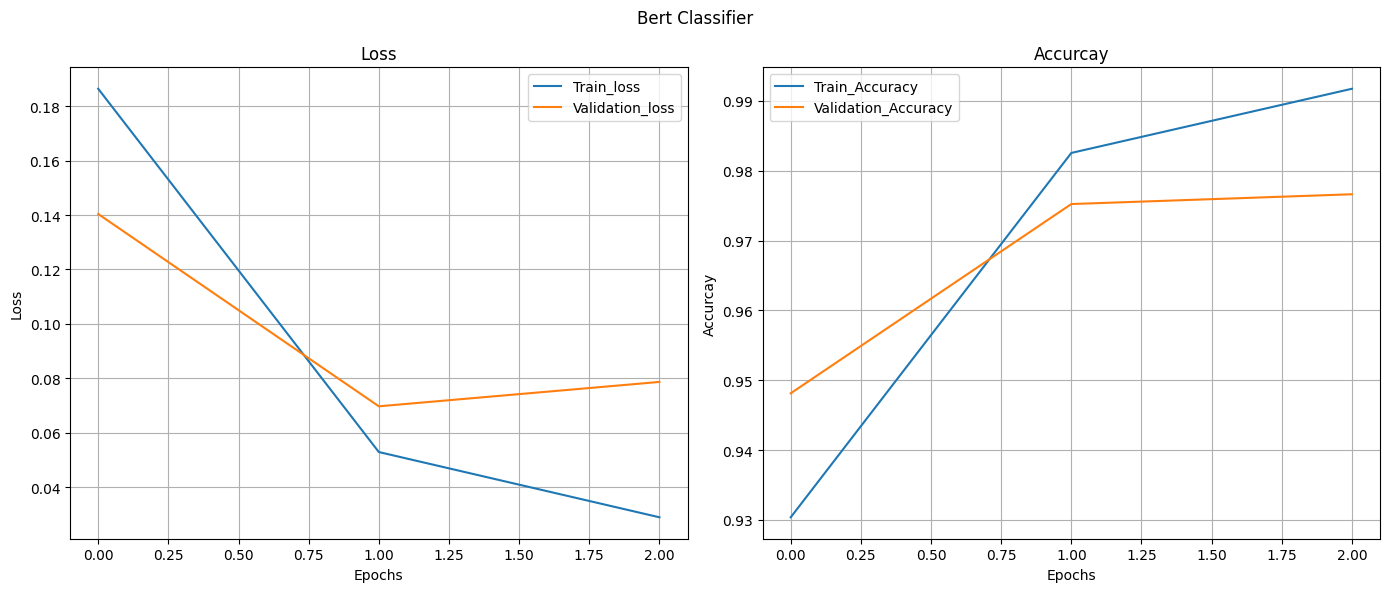

In [23]:
plot_resutl(bert_finetune_history, fig_size=(14, 6), name='Bert Classifier')

  0%|          | 0/535 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      1019
        real       0.98      0.98      0.98      1119

    accuracy                           0.98      2138
   macro avg       0.98      0.98      0.98      2138
weighted avg       0.98      0.98      0.98      2138

Confusion Matrix:


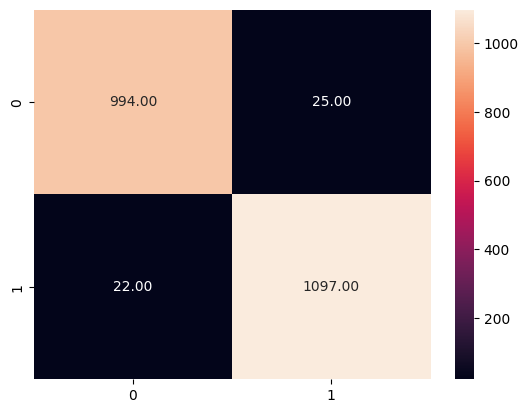

In [24]:
evaluate(bert_finetune_model, test_loader)

In [69]:
torch.save(bert_finetune_model.state_dict(), 'bert_finetune_model.pth')

# **Bert + BiGRU**

In [53]:
class BertBiGRUClassifier(nn.Module):
    def __init__(self, n_classes=1, hidden_dim=128, num_layers=1, bidirectional=True):
        super(BertBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.gru = nn.GRU(self.bert.config.hidden_size, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, token_type_ids):
        
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = bert_outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        gru_output, hidden = self.gru(sequence_output)  # hidden: (num_layers * num_directions, batch_size, hidden_dim)
        final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim * 2)
        output = self.out(final_hidden_state)
        
        return self.sigmoid(output)

In [57]:
hidden_dim = 128
num_layers = 1
bidirectional=True
n_classes = 1
bert_gru_finetune_model = BertBiGRUClassifier(n_classes, hidden_dim, num_layers, bidirectional).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(bert_gru_finetune_model.parameters(), lr=2e-5)

bert_gru_finetune_history = train(bert_gru_finetune_model, loss_fn, optimizer, EPOCHS = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.16 accuracy 93.57%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.09 accuracy 96.73%
Epoch 2/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.05 accuracy 98.43%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.06 accuracy 97.80%
Epoch 3/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.03 accuracy 99.11%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.09 accuracy 97.80%


In [100]:
count_parameters(bert_gru_finetune_model)

110172161

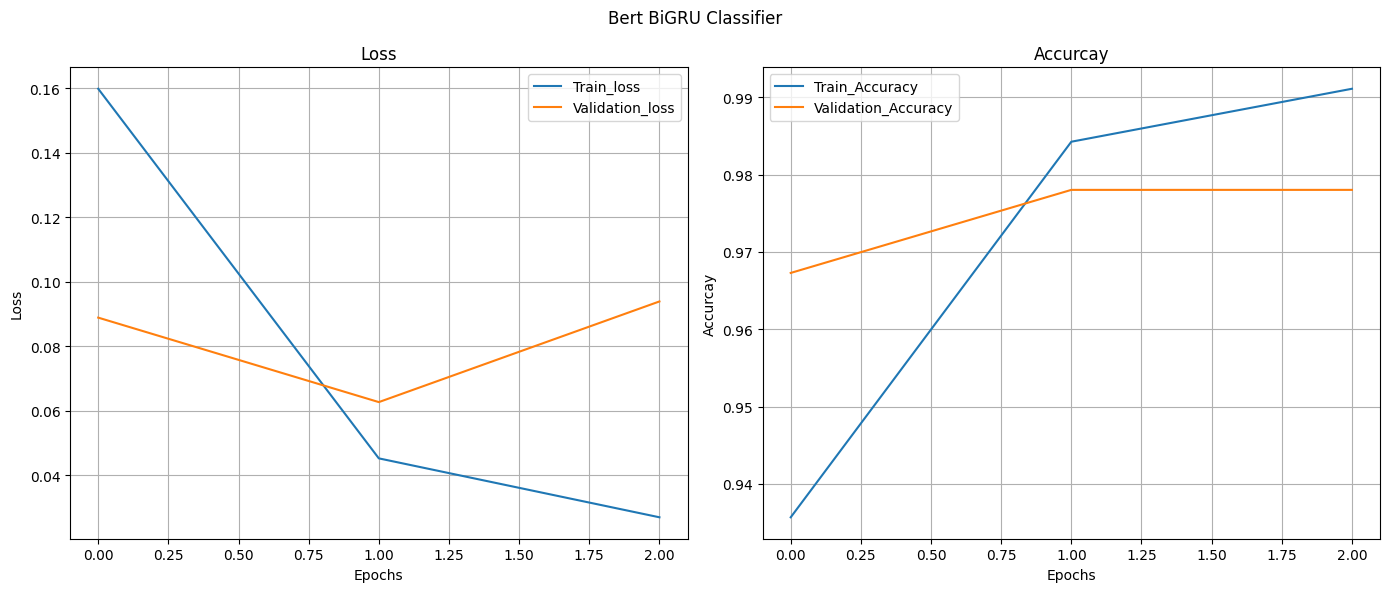

In [58]:
plot_resutl(bert_gru_finetune_history, fig_size=(14, 6), name='Bert BiGRU Classifier')

  0%|          | 0/535 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.98      0.98      1019
        real       0.99      0.97      0.98      1119

    accuracy                           0.98      2138
   macro avg       0.98      0.98      0.98      2138
weighted avg       0.98      0.98      0.98      2138

Confusion Matrix:


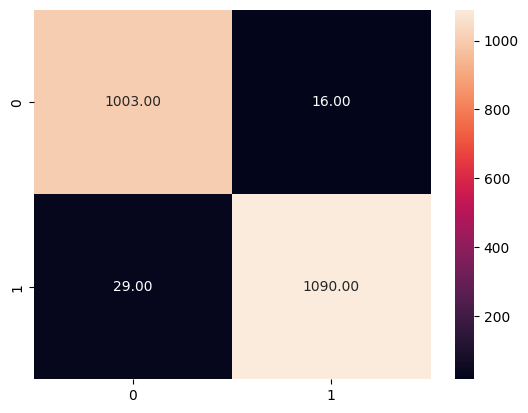

In [59]:
evaluate(bert_gru_finetune_model, test_loader)

In [68]:
torch.save(bert_gru_finetune_model.state_dict(), 'bert_gru_finetune_model.pth')

# **CT-BERT+BIGRU**

In [60]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [61]:
MAX_LEN = 128
BATCH_SIZE = 4

train_dataset = TweetDataset(
    tweets=train_tweets,
    labels=train_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = TweetDataset(
    tweets=val_tweets,
    labels=val_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = TweetDataset(
    tweets=test_tweets,
    labels=test_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
class CT_BertBiGRUClassifier(nn.Module):
    def __init__(self, n_classes=1, hidden_dim=128, num_layers=1, bidirectional=True):
        super(CT_BertBiGRUClassifier, self).__init__()
        self.ctbert = AutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")
        self.gru = nn.GRU(self.ctbert.config.hidden_size, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, n_classes)
        self.sigmoid = nn.Sigmoid()


    def forward(self, input_ids, attention_mask, token_type_ids):
        
        ctbert_outputs = self.ctbert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = ctbert_outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        gru_output, hidden = self.gru(sequence_output)  # hidden: (num_layers * num_directions, batch_size, hidden_dim)
        final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim * 2)
        output = self.out(final_hidden_state)
        
        return self.sigmoid(output)

In [63]:
hidden_dim = 128
num_layers = 1
bidirectional=True
n_classes = 1
ctbert_finetune_model = CT_BertBiGRUClassifier(n_classes, hidden_dim, num_layers, bidirectional).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(ctbert_finetune_model.parameters(), lr=1e-5)

ctbert_finetune_history = train(ctbert_finetune_model, loss_fn, optimizer, EPOCHS = 3)

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.12 accuracy 95.50%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.07 accuracy 97.34%
Epoch 2/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.03 accuracy 99.11%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.10 accuracy 96.54%
Epoch 3/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.01 accuracy 99.56%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.06 accuracy 98.13%


In [101]:
count_parameters(ctbert_finetune_model)

336028417

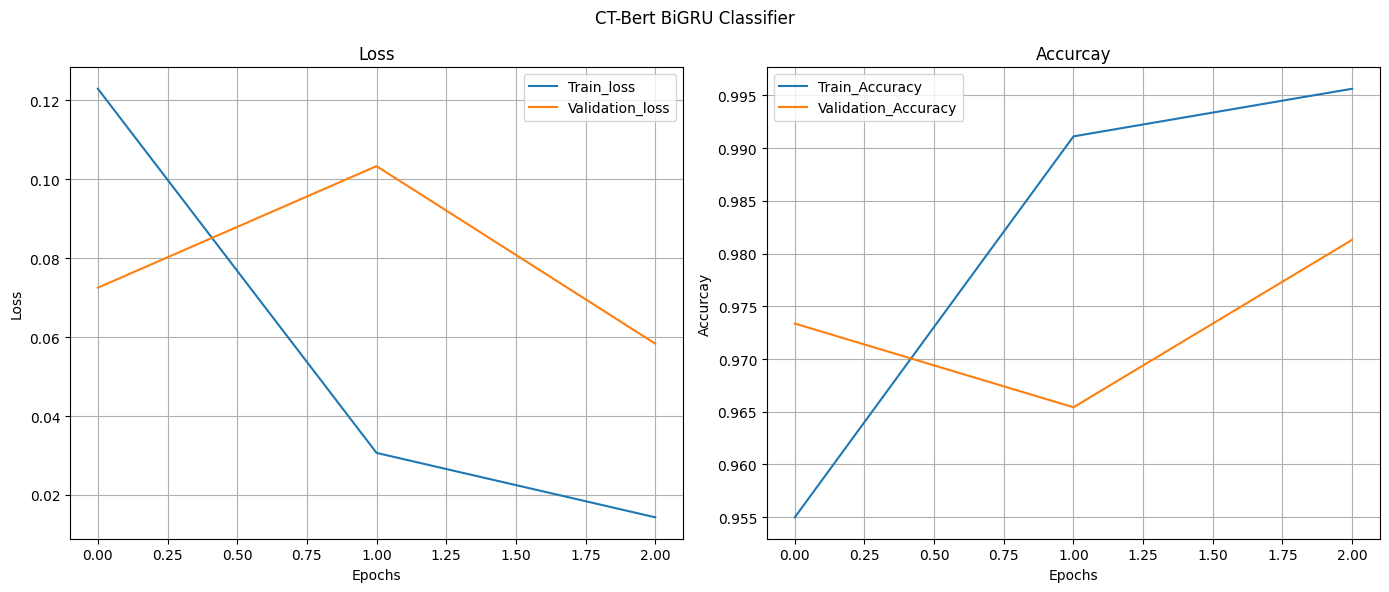

In [66]:
plot_resutl(ctbert_finetune_history, fig_size=(14, 6), name='CT-Bert BiGRU Classifier')

  0%|          | 0/535 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      1019
        real       0.98      0.98      0.98      1119

    accuracy                           0.98      2138
   macro avg       0.98      0.98      0.98      2138
weighted avg       0.98      0.98      0.98      2138

Confusion Matrix:


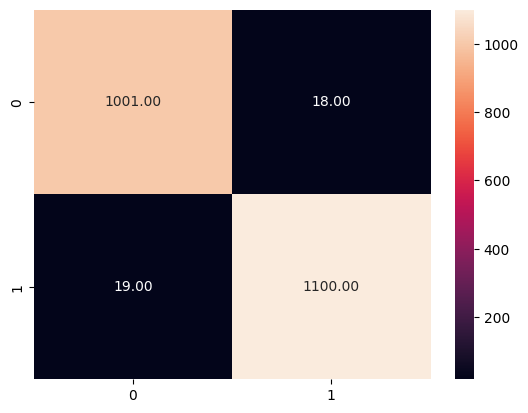

In [65]:
evaluate(ctbert_finetune_model, test_loader)

In [67]:
torch.save(ctbert_finetune_model.state_dict(), 'ctbert_finetune_model.pth')

# **PLM's BERT**

In [70]:
class BertBaseClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BertBaseClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()
        
        for param in self.bert.parameters():
            param.requires_grad = False 
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids= token_type_ids)
        pooled_output = outputs.pooler_output
        output = self.out(pooled_output)
        return self.sigmoid(output)

In [72]:
bert_plm_model = BertBaseClassifier(n_classes=1).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, bert_plm_model.parameters()), lr=2e-5)

bert_plm_history = train(bert_plm_model, loss_fn, optimizer, EPOCHS = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.69 accuracy 52.80%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.67 accuracy 68.04%
Epoch 2/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.66 accuracy 68.60%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.64 accuracy 75.05%
Epoch 3/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.63 accuracy 72.65%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.61 accuracy 73.97%


In [102]:
count_parameters(bert_plm_model)

769

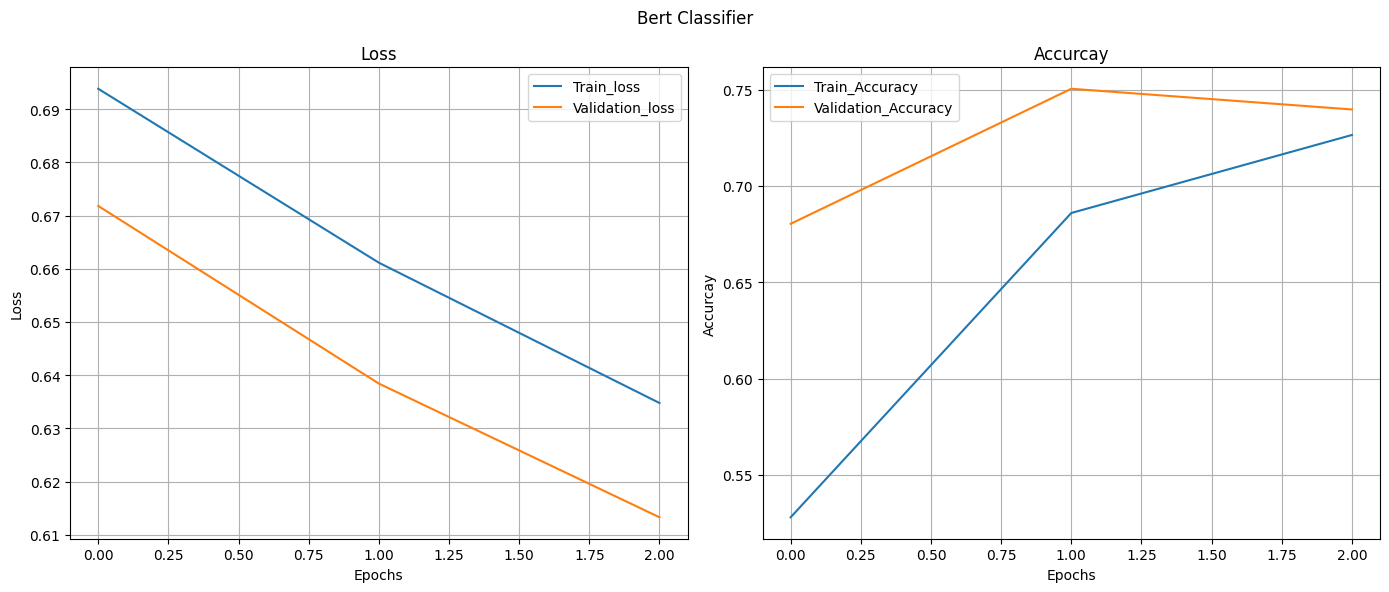

In [73]:
plot_resutl(bert_plm_history, fig_size=(14, 6), name='Bert Classifier')

  0%|          | 0/535 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.46      0.62      1019
        real       0.67      0.98      0.79      1119

    accuracy                           0.73      2138
   macro avg       0.81      0.72      0.71      2138
weighted avg       0.80      0.73      0.71      2138

Confusion Matrix:


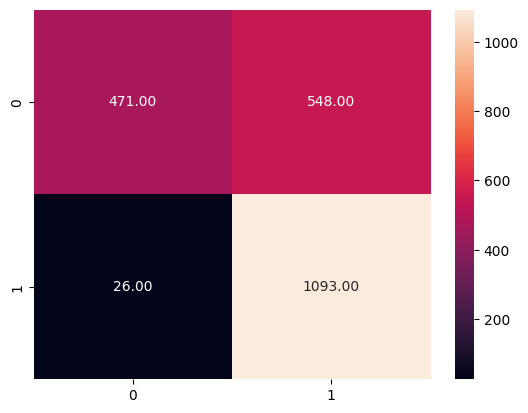

In [74]:
evaluate(bert_plm_model, test_loader)

In [91]:
get_wrong_prediction(bert_plm_model, test_loader)

  0%|          | 0/535 [00:00<?, ?it/s]

1->  Kuwait  Assistant Undersecretary for Public Health Affairs Dr Buthayna Almodaf highlighted the importance of risk communication &amp; public education in fighting #COVID19. The country increased testing capacity enabling 400000 people to be tested.
TRUE LABEL-> 1
PREDICTION-> 0.0
#################################################################
1-> Kids reach ‘f**k this shit’ stage of lockdown https://t.co/swClEhi2Iq
TRUE LABE-> 0
PREDICTION-> 1.0


In [75]:
torch.save(bert_plm_model.state_dict(), 'bert_plm_model.pth')

# **PLM's BERT+BiGRU**

In [92]:
class BertBiGRUClassifier(nn.Module):
    def __init__(self, n_classes, hidden_dim=128, num_layers=1, bidirectional=True):
        super(BertBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.gru = nn.GRU(self.bert.config.hidden_size, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, n_classes)
        self.sigmoid = nn.Sigmoid()
        
        for param in self.bert.parameters():
            param.requires_grad = False 

    def forward(self, input_ids, attention_mask, token_type_ids):
        
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = bert_outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        gru_output, hidden = self.gru(sequence_output)  # hidden: (num_layers * num_directions, batch_size, hidden_dim)
        final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim * 2)
        output = self.out(final_hidden_state)
        
        return self.sigmoid(output)

In [93]:
hidden_dim = 128
num_layers = 1
bidirectional=True
n_classes = 1
bert_gru_plm_model = BertBiGRUClassifier(n_classes, hidden_dim, num_layers, bidirectional).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, bert_gru_plm_model.parameters()), lr=2e-5)

bert_gru_plm_history = train(bert_gru_plm_model, loss_fn, optimizer, EPOCHS = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.43 accuracy 82.99%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.26 accuracy 89.77%
Epoch 2/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.22 accuracy 90.76%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.19 accuracy 92.29%
Epoch 3/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.18 accuracy 93.18%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.17 accuracy 93.32%


In [103]:
count_parameters(bert_gru_plm_model)

689921

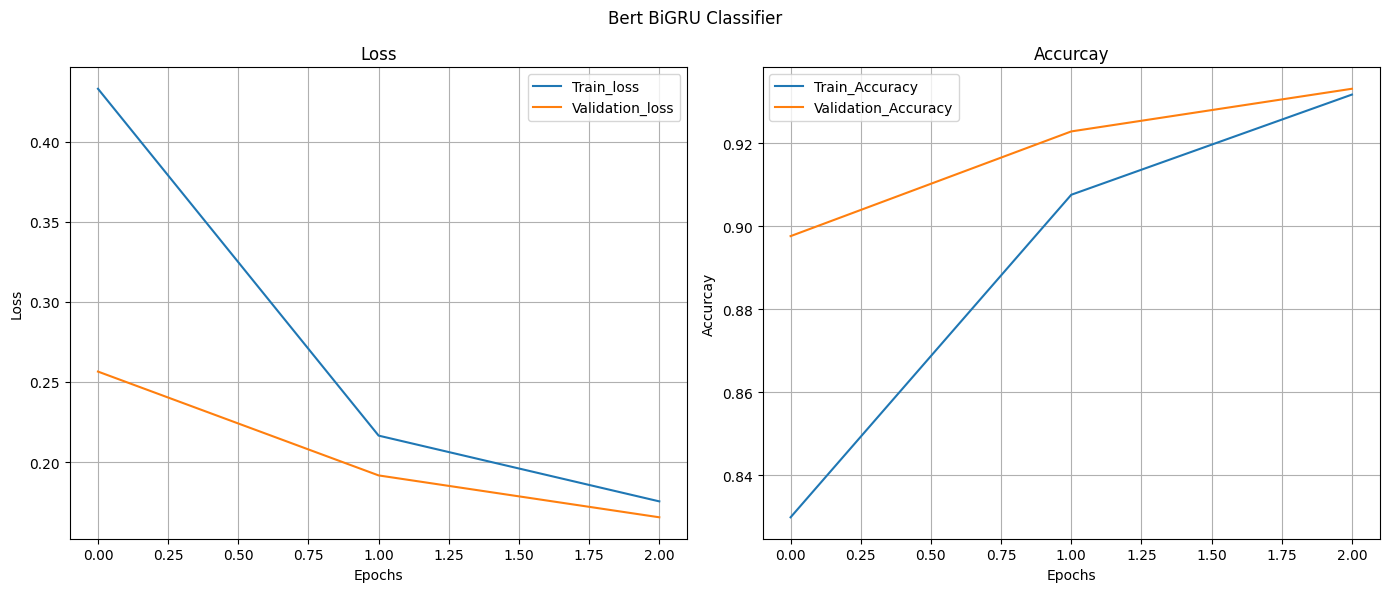

In [94]:
plot_resutl(bert_gru_plm_history, fig_size=(14, 6), name='Bert BiGRU Classifier')

  0%|          | 0/535 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.93      0.92      1019
        real       0.93      0.93      0.93      1119

    accuracy                           0.93      2138
   macro avg       0.93      0.93      0.93      2138
weighted avg       0.93      0.93      0.93      2138

Confusion Matrix:


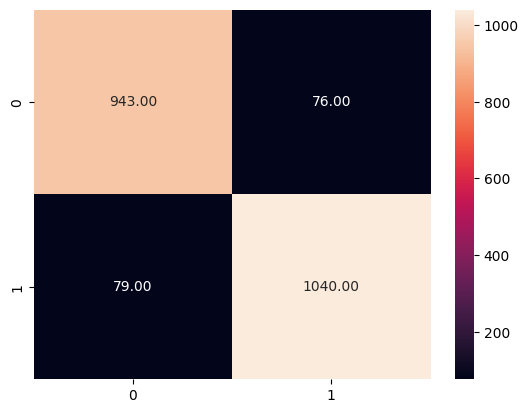

In [95]:
evaluate(bert_gru_plm_model, test_loader)

In [96]:
get_wrong_prediction(bert_gru_plm_model, test_loader)

  0%|          | 0/535 [00:00<?, ?it/s]

1-> The underlying cause of death in the vast majority of death certificates that mention COVID-19 is the coronavirus. https://t.co/Hg4O4AQZ3X
TRUE LABEL-> 0
PREDICTION-> 1.0
#################################################################
1-> In response to the pandemic Pennsylvania Governor Tom Wolf shut down nonessential businesses and limited gatherings in May. A federal judge’s rules that these COVID restrictions were unconstitutional violating the First and Fourteenth Amendments. @thehill https://t.co/Y9fDeXe7mf
TRUE LABE-> 1
PREDICTION-> 0.0


In [97]:
torch.save(bert_gru_plm_model.state_dict(), 'bert_gru_plm_model.pth')

# **PLM's CT-BERT+BiGRU**

In [10]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
MAX_LEN = 128
BATCH_SIZE = 4

train_dataset = TweetDataset(
    tweets=train_tweets,
    labels=train_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = TweetDataset(
    tweets=val_tweets,
    labels=val_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = TweetDataset(
    tweets=test_tweets,
    labels=test_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
class CT_BertBiGRUClassifier(nn.Module):
    def __init__(self, n_classes, hidden_dim=128, num_layers=1, bidirectional=True):
        super(CT_BertBiGRUClassifier, self).__init__()
        self.ctbert = AutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")
        self.gru = nn.GRU(self.ctbert.config.hidden_size, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, n_classes)
        self.sigmoid = nn.Sigmoid()
        
        for param in self.ctbert.parameters():
            param.requires_grad = False 

    def forward(self, input_ids, attention_mask, token_type_ids):
        
        ctbert_outputs = self.ctbert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = ctbert_outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        gru_output, hidden = self.gru(sequence_output)  # hidden: (num_layers * num_directions, batch_size, hidden_dim)
        final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim * 2)
        output = self.out(final_hidden_state)
        
        return self.sigmoid(output)

In [13]:
hidden_dim = 128
num_layers = 1
bidirectional=True
n_classes = 1
ct_bert_plm_model = CT_BertBiGRUClassifier(n_classes, hidden_dim, num_layers, bidirectional).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ct_bert_plm_model.parameters()), lr=1e-5)


ct_bert_plm_history = train(ct_bert_plm_model, loss_fn, optimizer, EPOCHS = 3)

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.50 accuracy 80.51%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.34 accuracy 90.05%
Epoch 2/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.28 accuracy 91.87%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.21 accuracy 92.66%
Epoch 3/3
--------------------------------------------------


  0%|          | 0/1605 [00:00<?, ?it/s]

Train loss 0.18 accuracy 93.68%


  0%|          | 0/535 [00:00<?, ?it/s]

Val   loss 0.15 accuracy 94.53%


In [14]:
count_parameters(ct_bert_plm_model)

886529

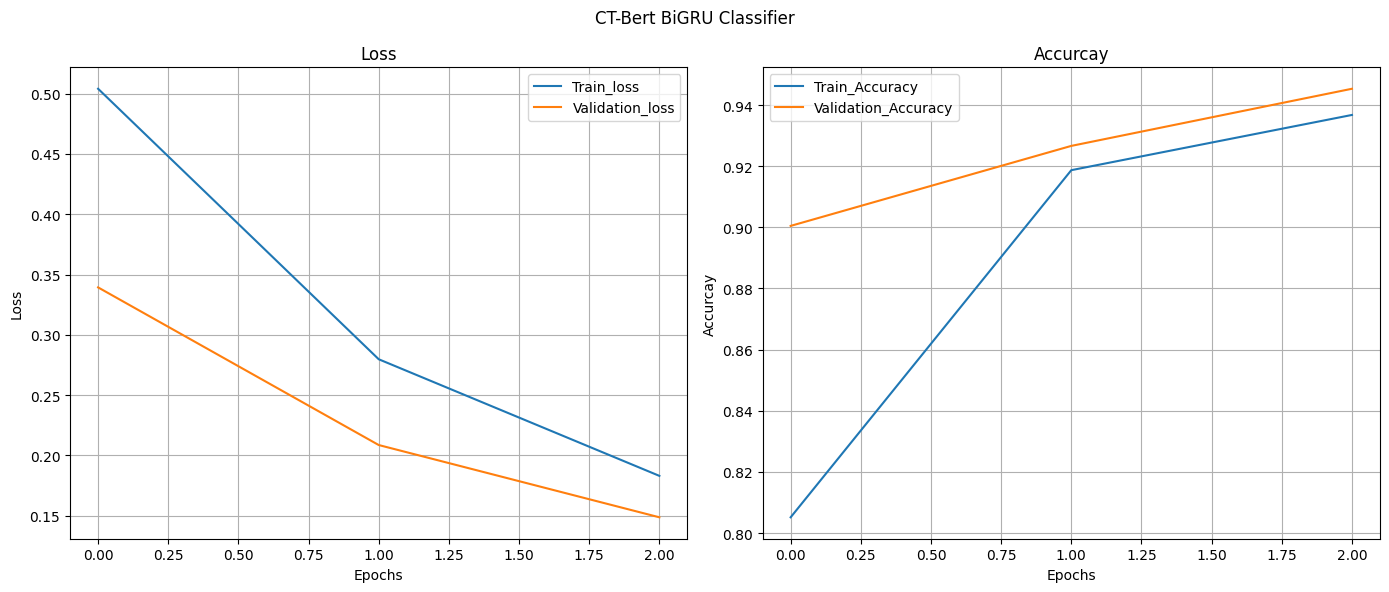

In [15]:
plot_resutl(ct_bert_plm_history, fig_size=(14, 6), name='CT-Bert BiGRU Classifier')

  0%|          | 0/535 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.93      0.94      1019
        real       0.94      0.95      0.95      1119

    accuracy                           0.94      2138
   macro avg       0.94      0.94      0.94      2138
weighted avg       0.94      0.94      0.94      2138

Confusion Matrix:


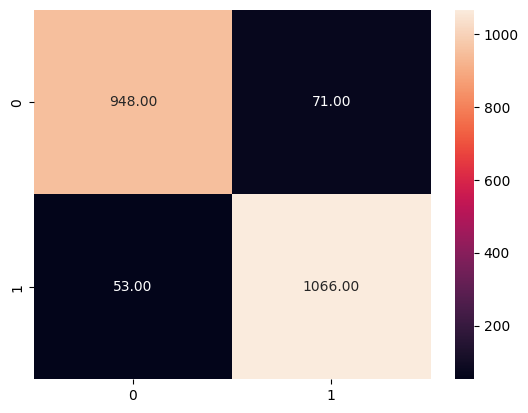

In [16]:
evaluate(ct_bert_plm_model, test_loader)

In [17]:
get_wrong_prediction(ct_bert_plm_model, test_loader)

  0%|          | 0/535 [00:00<?, ?it/s]

1-> The underlying cause of death in the vast majority of death certificates that mention COVID-19 is the coronavirus. https://t.co/Hg4O4AQZ3X
TRUE LABEL-> 0
PREDICTION-> 1.0
#################################################################
1-> In response to the pandemic Pennsylvania Governor Tom Wolf shut down nonessential businesses and limited gatherings in May. A federal judge’s rules that these COVID restrictions were unconstitutional violating the First and Fourteenth Amendments. @thehill https://t.co/Y9fDeXe7mf
TRUE LABE-> 1
PREDICTION-> 0.0


In [18]:
torch.save(ct_bert_plm_model.state_dict(), 'ct_bert_plm_model.pth')

# Compare loss and accuracy

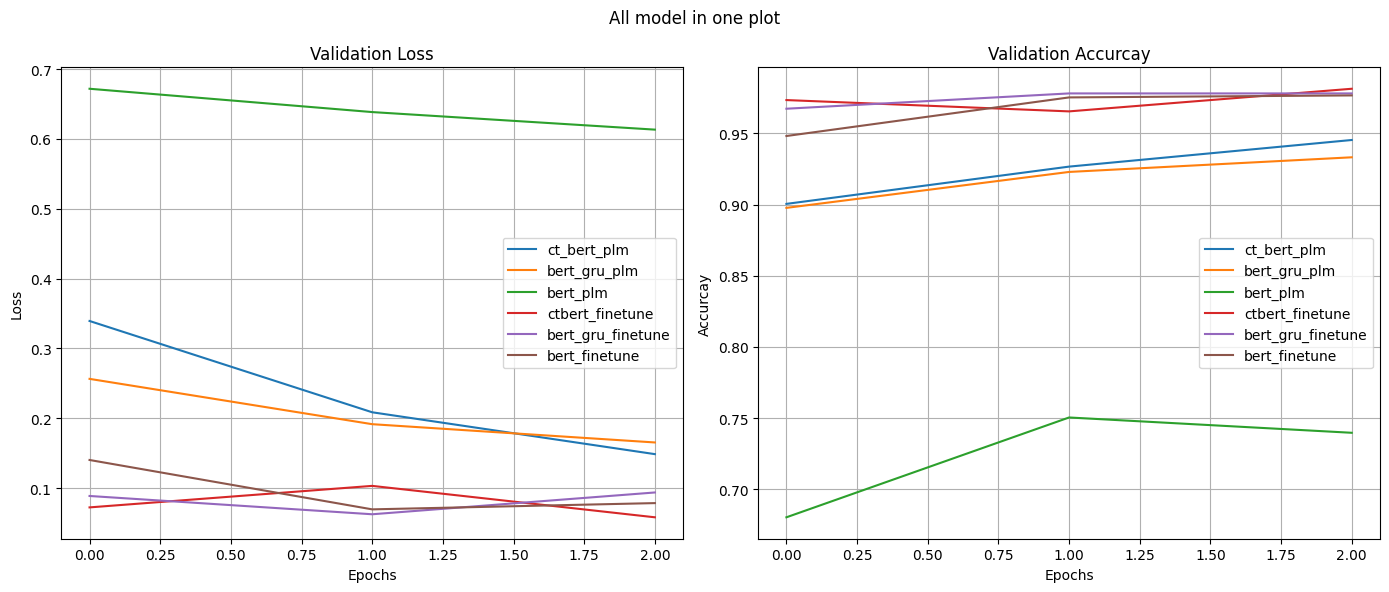

In [19]:
plt.figure(figsize=(14, 6))
plt.suptitle('All model in one plot')

plt.subplot(1,2,1)

plt.plot(ct_bert_plm_history['val_loss'], label='ct_bert_plm')
plt.plot(bert_gru_plm_history['val_loss'], label='bert_gru_plm')
plt.plot(bert_plm_history['val_loss'], label='bert_plm')
plt.plot(ctbert_finetune_history['val_loss'], label='ctbert_finetune')
plt.plot(bert_gru_finetune_history['val_loss'], label='bert_gru_finetune')
plt.plot(bert_finetune_history['val_loss'], label='bert_finetune')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axis()
plt.grid()

plt.subplot(1,2,2)

plt.plot(ct_bert_plm_history['val_accuracy'], label='ct_bert_plm')
plt.plot(bert_gru_plm_history['val_accuracy'], label='bert_gru_plm')
plt.plot(bert_plm_history['val_accuracy'], label='bert_plm')
plt.plot(ctbert_finetune_history['val_accuracy'], label='ctbert_finetune')
plt.plot(bert_gru_finetune_history['val_accuracy'], label='bert_gru_finetune')
plt.plot(bert_finetune_history['val_accuracy'], label='bert_finetune')

plt.title('Validation Accurcay')
plt.xlabel('Epochs')
plt.ylabel('Accurcay')
plt.legend()
plt.axis()
plt.grid()

plt.tight_layout()
plt.show()